In [1]:
import ee 
import geopandas as gpd
from shapely import wkt

import os
import numpy as np

import rasterio
from rasterio.plot import show
from osgeo import gdal

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# #load country
# n = 'TUR'
# #load envelope
# path = '/Users/Zack/0_seawarden/0_search_areas/1_envelope/' + n + '_envelope.shp'
# envelope = gpd.read_file(path)

In [3]:
# #extract coordinates
# coord = wkt.dumps(envelope['geometry'][0])
# coord.split()

# x1=coord.split()[1].split('(')[2]
# y1=coord.split()[2].split(',')[0]
# x2=coord.split()[3]
# y2=coord.split()[4].split(',')[0]
# x3=coord.split()[5]
# y3=coord.split()[6].split(',')[0]
# x4=coord.split()[7]
# y4=coord.split()[8].split(',')[0]

# #format region request
# region = '[[' + x1 + ',' + y1 + '], [' + x2 + ',' + y2 + '], [' + x3 + ',' + y3 + '], [' + x4 + ',' + y4 + ']]'

In [1]:
# # download data via google earth engine API
# # https://www.earthdatascience.org/tutorials/intro-google-earth-engine-python-api/

# ee.Initialize() #run earthengine authenticate in conda
# #image1 = ee.Image('srtm90_v4')
# image1 = ee.Image('JAXA/ALOS/AW3D30/V2_2') #.clip(aoi['geometry'])
# path = image1.select('AVE_DSM').getDownloadUrl({
#     'scale': 90,
#     'crs': 'EPSG:4326',
#     #'region': '[[19.028, 34.615], [28.432,34.615], [28.432,41.804], [19.028,41.804]]'
#     'region': region
# })
# print(path)

In [2]:
#load dem raster file
folder = '/Users/Zack/0_dem/alos/'
#folder = '/Users/Zack/0_GIS_Greece/dem_strm90/'
#folder = '/Users/Zack/0_bing/detections_1+ positive/'
#folder = '/Users/Zack/0_bing/detections_1+/detections/' #yolo v3 predictions
#folder = '/Users/Zack/0_bing/images_1km_2019-10-13/' #control data
#folder = '/Users/Zack/0_bing/images_1km_2020-02-08/'#all SAR predictions

#out_folder = '/Users/Zack/Desktop/temp/'

images = os.listdir(folder)
print("total number of images:", len(images))
images

total number of images: 19


['dem_alos_30m_FRO-0000000000-0000000000.tif',
 'dem_alos_30m_FRO-0000000000-0000000000.tif.ovr',
 'dem_alos_30m_FRO-0000000000-0000046592.tif',
 'dem_alos_30m_FRO-0000000000-0000046592.tif.ovr',
 'dem_alos_30m_GBR-0000000000-0000000000.tif',
 'dem_alos_30m_GBR-0000000000-0000000000.tif.ovr',
 'dem_alos_30m_GBR-0000000000-0000046592.tif',
 'dem_alos_30m_GBR-0000000000-0000046592.tif.ovr',
 'dem_alos_30m_GBR-0000046592-0000000000.tif',
 'dem_alos_30m_GBR-0000046592-0000000000.tif.ovr',
 'dem_alos_30m_GBR-0000046592-0000046592.tif',
 'dem_alos_30m_GBR-0000046592-0000046592.tif.ovr',
 'dem_alos_30m_IRL.tif',
 'dem_alos_30m_NOR-0000000000-0000000000.tif',
 'dem_alos_30m_NOR-0000000000-0000046592.tif',
 'dem_alos_30m_NOR-0000000000-0000093184.tif',
 'dem_alos_30m_NOR-0000046592-0000000000.tif',
 'dem_alos_30m_NOR-0000046592-0000046592.tif',
 'dem_alos_30m_NOR-0000046592-0000093184.tif']

In [4]:
images[0]

'dem_alos_30m_FRO-0000000000-0000000000.tif'

In [6]:
dem = images[0]
#dem = 'srtm90_v4.elevation.tif'
print(folder + dem)

#display dem raster file
# https://automating-gis-processes.github.io/CSC/notebooks/L5/plotting-raster.html

data_dir = folder + dem
fp = os.path.join(data_dir)
raster = rasterio.open(fp)

fig = plt.figure(figsize = (20, 8))
show((raster, 1), cmap='gray')

/Users/Zack/0_dem/alos/dem_alos_30m_FRO-0000000000-0000000000.tif


RasterioIOError: This is a BigTIFF file.  BigTIFF is not supported by this version of GDAL and libtiff.

In [21]:
#open raster file for conversion to generate coastline binary raster 
#https://pcjericks.github.io/py-gdalogr-cookbook/raster_layers.html

driver = gdal.GetDriverByName('GTiff')
file = gdal.Open(filepath + dem)
band = file.GetRasterBand(1)
lista = band.ReadAsArray()

# reclassification    
lista[np.where( lista < 1 )] = 1
lista[np.where( lista > 1 )] = 2

In [22]:
# create new file
out_file = (filepath + 'test.tif')  
file2 = driver.Create(out_file, file.RasterXSize , file.RasterYSize , 1)
file2.GetRasterBand(1).WriteArray(lista)

# spatial ref system ???
proj = file.GetProjection()
georef = file.GetGeoTransform()
file2.SetProjection(proj)
file2.SetGeoTransform(georef)
file2.FlushCache()

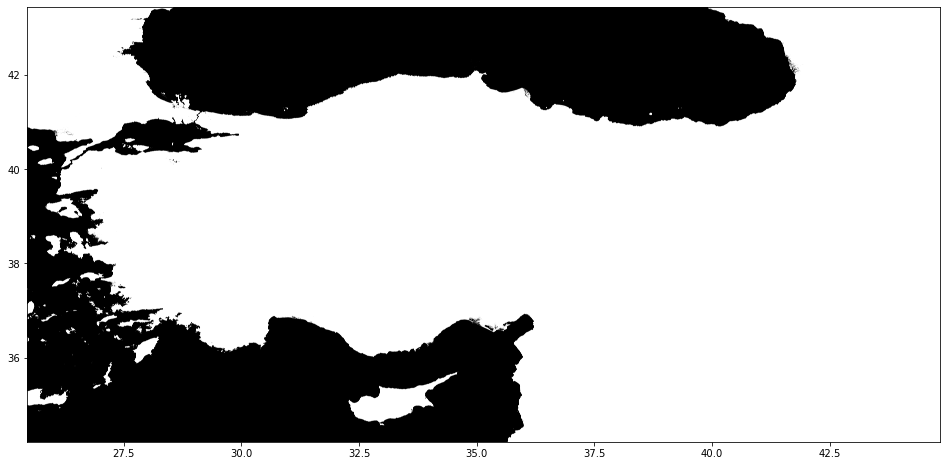

In [23]:
#generate new raster
#data_dir = (filepath + 'srtm90_v4.reclass.tif') 
data_dir = (filepath + 'test.tif') 
fp = os.path.join(data_dir)
raster = rasterio.open(fp)

#display new raster
fig = plt.figure(figsize = (20, 8))
show((raster, 1), cmap='gray')

In [33]:
aoi = gpd.read_file('../0_search_areas/4_search_area/search_area_100m_' + n + '.shp')
aoi = aoi.to_crs({'init': 'EPSG:4326'})
print('crop extent crs: ', aoi.crs)
print('dem crs: ', raster.crs)

crop extent crs:  {'init': 'EPSG:4326'}
dem crs:  EPSG:4326


In [ ]:
out_file = (filepath + 'test2.tif')  
file2 = driver.Create(out_file, file.RasterXSize , file.RasterYSize , 1)
file2.GetRasterBand(1).WriteArray(lista)

# spatial ref system ???
proj = file.GetProjection()
georef = file.GetGeoTransform()
file2.SetProjection(proj)
file2.SetGeoTransform(georef)
file2.FlushCache()